# Time Serie Predictions

## Dataset: Monthly Milk Production

Source: https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv("monthly-milk-production.csv", index_col="Month")

In [3]:
df.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 1962-01-01 01:00:00 to 1975-12-01 01:00:00
Data columns (total 1 columns):
Milk Production    168 non-null float64
dtypes: float64(1)
memory usage: 2.6+ KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Milk Production,168.0,754.708333,102.204524,553.0,677.75,761.0,824.5,969.0


In [6]:
# Making the index as a time serie
df.index = pd.to_datetime(df.index)

In [7]:
len(df)

168

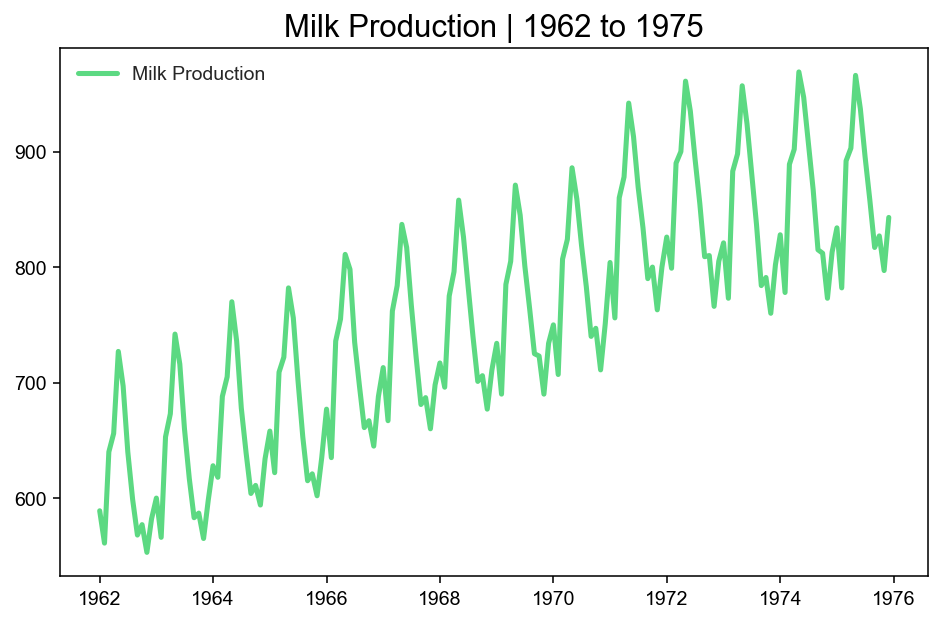

In [8]:
# Let's check the data

plt.figure(dpi=140, figsize=(8,5))

plt.title("Milk Production | 1962 to 1975", fontsize=16)

sns.set_style("whitegrid", {'grid.color': "0.95"})

plt.plot(df.index, df["Milk Production"], color="#5cd982", lw=2.6, label="Milk Production")

plt.legend()

# plt.show()

In [9]:
# Let's try to predict the 1975 year production (last year that we've got)

# Split the training (pre 1975) and testing data (1975)
train = df[df.index.year < 1975]

test = df[df.index.year == 1975]

In [10]:
train.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


In [11]:
test.head()

,Milk Production
Month,
1975-01-01 01:00:00,834.0
1975-02-01 01:00:00,782.0
1975-03-01 01:00:00,892.0
1975-04-01 01:00:00,903.0
1975-05-01 01:00:00,966.0


In [12]:
# Let's scale the datas

from sklearn.preprocessing import MinMaxScaler

# instantiate the scaler
scaler = MinMaxScaler()

# Fit the model with the training set (no cheating)
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [13]:
# Create the scaledTrain and the scaledTest dataframe
scaledTrain = pd.DataFrame(data=scaler.transform(train), index=train.index, columns=train.columns)

scaledTest = pd.DataFrame(data=scaler.transform(test), index=test.index, columns=test.columns)

In [14]:
scaledTrain.head()

,Milk Production
Month,
1962-01-01 01:00:00,0.086538
1962-02-01 01:00:00,0.019231
1962-03-01 01:00:00,0.209135
1962-04-01 01:00:00,0.247596
1962-05-01 01:00:00,0.418269


In [15]:
scaledTest

,Milk Production
Month,
1975-01-01 01:00:00,0.675481
1975-02-01 01:00:00,0.550481
1975-03-01 01:00:00,0.814904
1975-04-01 01:00:00,0.841346
1975-05-01 01:00:00,0.992788
1975-06-01 01:00:00,0.923077
1975-07-01 01:00:00,0.824519
1975-08-01 01:00:00,0.733173
1975-09-01 01:00:00,0.634615


In [16]:
# Create the next_batch function

def next_batch(training_data,batch_size,steps):
    """
    INPUT: Data, Batch Size, Time Steps per batch
    OUTPUT: A tuple of y time series results. y[:,:-1] and y[:,1:]
    """
    
    # Set a random starting point index for the batch
    random_start = np.random.randint(0.0, len(training_data)-(steps+1), size=[batch_size])[0]
    
    # Index the data from the random start & reshape this data to be (1,steps+1)
    y_batch = training_data.iloc[random_start: (random_start+steps+1)]["Milk Production"].reshape(1,steps+1)
    
    
    # Return the 2 batches reshaped (-1,steps,1) into tensors for the RNN
    return y_batch[:,:-1].reshape(-1, steps, 1), y_batch[:,1:].reshape(-1, steps, 1)
    

In [17]:
# Create the constants

num_inputs = 1
num_time_steps = 12
num_neurons = 120
num_outputs = 1

learning_rate = 0.0003
num_training_steps = 4001
batch_size = 1

In [18]:
# Create the placeholders
X = tf.placeholder(tf.float32, shape=[None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, shape=[None, num_time_steps, num_outputs])

In [19]:
# Creating the RNN 
cell = tf.contrib.rnn.OutputProjectionWrapper(
    (tf.contrib.rnn.LSTMCell(num_units=num_neurons, activation=tf.nn.relu)),
    output_size=num_outputs)

In [20]:
outputs, states = tf.nn.dynamic_rnn(cell=cell, inputs=X, dtype=tf.float32)

In [21]:
# Loss function (MSE)
loss = tf.reduce_mean(tf.square(outputs-y))

# Create the optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

# Create the trainer
train = optimizer.minimize(loss)

In [22]:
# Init the global variables
init = tf.global_variables_initializer()

In [23]:
# Create the saver
saver = tf.train.Saver()

In [24]:
# Session time

mse_lst = []

with tf.Session() as sess:
    
    sess.run(init)
    
    for iteration in range(num_training_steps):
        
        batch_X, batch_y = next_batch(scaledTrain, batch_size, num_time_steps)
        
        sess.run(train, feed_dict={X:batch_X, y:batch_y})
        
    
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X:batch_X, y:batch_y})
            print(f"At iteration: \t{iteration} \t => \t MSE: \t {mse}")
            mse_lst.append([iteration, mse])
            
    # Save Model for Later
    saver.save(sess, "./ex_time_series_model_new")

/Users/Rioux/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()


At iteration: 	0 	 => 	 MSE: 	 0.06419458240270615
At iteration: 	100 	 => 	 MSE: 	 0.09805653244256973
At iteration: 	200 	 => 	 MSE: 	 0.02460644580423832
At iteration: 	300 	 => 	 MSE: 	 0.03479201719164848
At iteration: 	400 	 => 	 MSE: 	 0.04166563227772713
At iteration: 	500 	 => 	 MSE: 	 0.017063623294234276
At iteration: 	600 	 => 	 MSE: 	 0.036118101328611374
At iteration: 	700 	 => 	 MSE: 	 0.015332645736634731
At iteration: 	800 	 => 	 MSE: 	 0.023108601570129395
At iteration: 	900 	 => 	 MSE: 	 0.014511634595692158
At iteration: 	1000 	 => 	 MSE: 	 0.023168692365288734
At iteration: 	1100 	 => 	 MSE: 	 0.019047610461711884
At iteration: 	1200 	 => 	 MSE: 	 0.018508518114686012
At iteration: 	1300 	 => 	 MSE: 	 0.016721514984965324
At iteration: 	1400 	 => 	 MSE: 	 0.011613274924457073
At iteration: 	1500 	 => 	 MSE: 	 0.010166867636144161
At iteration: 	1600 	 => 	 MSE: 	 0.012120834551751614
At iteration: 	1700 	 => 	 MSE: 	 0.006574612110853195
At iteration: 	1800 	 => 	 

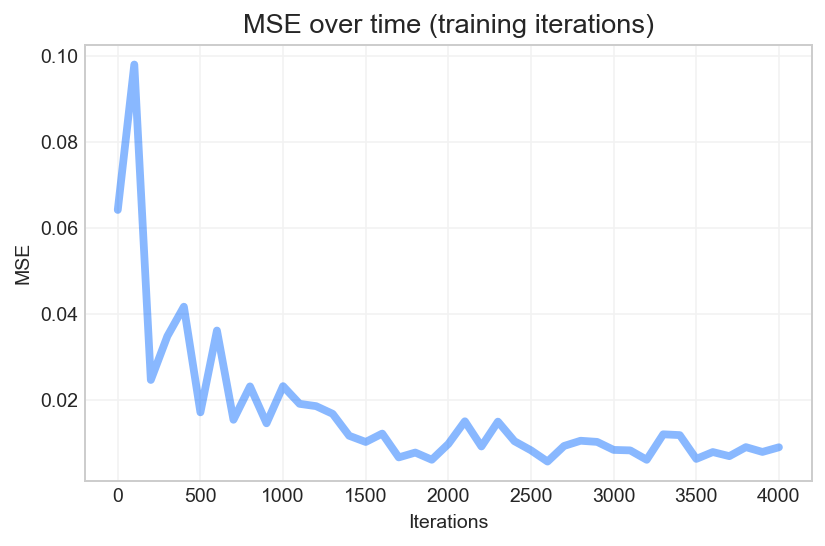

In [25]:
# Plot the mean squared error over training iterations

plt.figure(dpi=140)
plt.title("MSE over time (training iterations)", fontsize=14)
plt.plot([x[0] for x in mse_lst], [x[1] for x in mse_lst], lw=4, c="#1472ff", alpha=0.5)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.tight_layout()

In [26]:
# Here what's we're trying to predict
scaledTest

,Milk Production
Month,
1975-01-01 01:00:00,0.675481
1975-02-01 01:00:00,0.550481
1975-03-01 01:00:00,0.814904
1975-04-01 01:00:00,0.841346
1975-05-01 01:00:00,0.992788
1975-06-01 01:00:00,0.923077
1975-07-01 01:00:00,0.824519
1975-08-01 01:00:00,0.733173
1975-09-01 01:00:00,0.634615


In [27]:
with tf.Session() as sess:
    
    # Restore saved rnn time series model
    saver.restore(sess, "./ex_time_series_model_new")

        
    X_for_pred = scaledTrain[-num_time_steps:].values.reshape(-1, num_time_steps, 1)

    y_pred = sess.run(outputs, feed_dict={X:X_for_pred})
    

INFO:tensorflow:Restoring parameters from ./ex_time_series_model_new


In [28]:
scaledTest

,Milk Production
Month,
1975-01-01 01:00:00,0.675481
1975-02-01 01:00:00,0.550481
1975-03-01 01:00:00,0.814904
1975-04-01 01:00:00,0.841346
1975-05-01 01:00:00,0.992788
1975-06-01 01:00:00,0.923077
1975-07-01 01:00:00,0.824519
1975-08-01 01:00:00,0.733173
1975-09-01 01:00:00,0.634615


In [29]:
scaled_true = pd.concat([scaledTrain, scaledTest])

In [30]:
y_pred_df = pd.DataFrame(y_pred[0], index=scaledTest.index,columns=["Milk Production"])

In [31]:
scaled_pred = pd.concat([scaledTrain, y_pred_df])

In [32]:
final_pred_df = pd.DataFrame(scaler.inverse_transform(scaled_pred), index=df.index,columns=["Milk Production"])

In [33]:
final_pred_df.tail()

,Milk Production
Month,
1975-08-01 01:00:00,848.821857
1975-09-01 01:00:00,815.870008
1975-10-01 01:00:00,816.636265
1975-11-01 01:00:00,799.266350
1975-12-01 01:00:00,830.347475


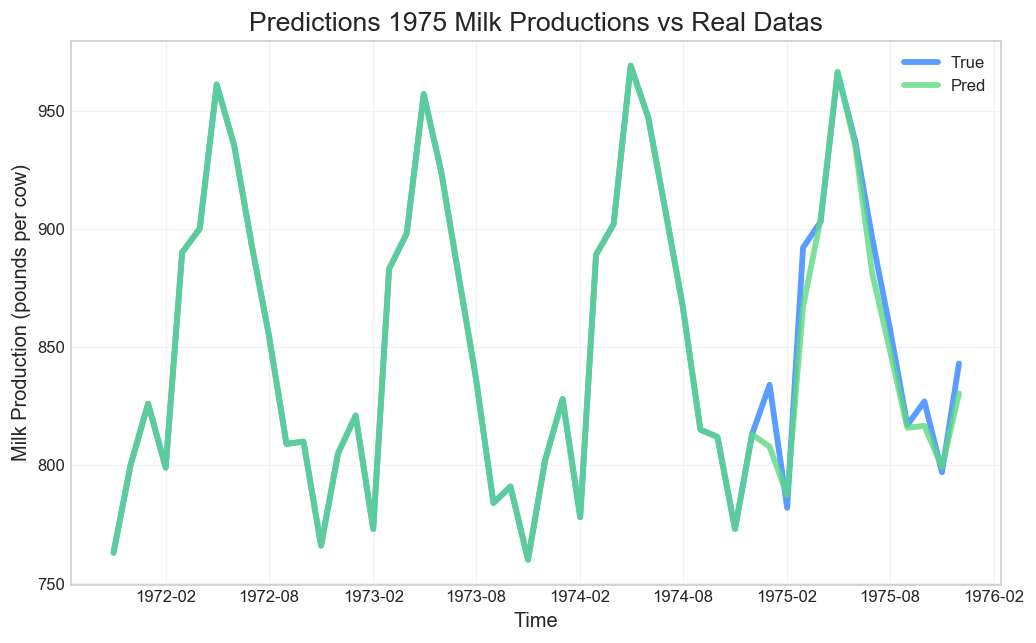

In [136]:
plt.figure(figsize=(10,6), dpi=120)

plt.plot(df[-50:], "#1472ff", alpha=0.7, label="True", lw=3.5)
plt.plot(final_pred_df[-50:], "#5cd982", alpha=0.8, label="Pred", lw=3.5)
plt.title("Predictions 1975 Milk Productions vs Real Datas", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Milk Production (pounds per cow)", fontsize=12)

plt.legend()

In [102]:
df[-13:-12].index

DatetimeIndex(['1974-12-01 01:00:00'], dtype='datetime64[ns]', name='Month', freq=None)

[]

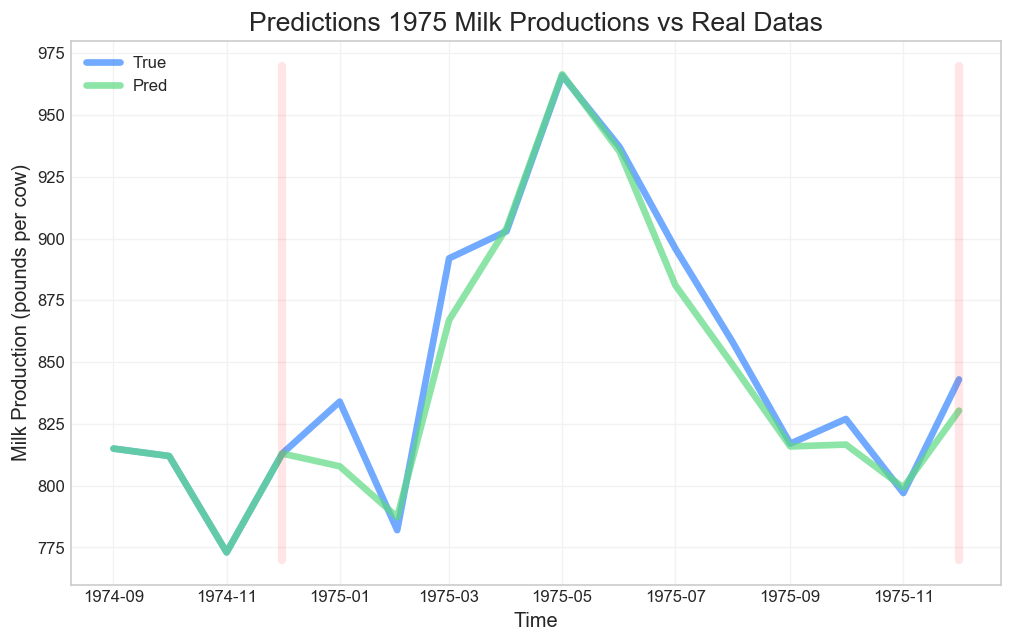

In [146]:
plt.figure(figsize=(10,6), dpi=120)

plt.title("Predictions 1975 Milk Productions vs Real Datas", fontsize=16)
plt.plot(df[-16:], "#1472ff", alpha=0.6, label="True", lw=4)
plt.plot(final_pred_df[-16:], "#5cd982", alpha=0.7, label="Pred", lw=4)

# Add starting point and final point of the predictions
plt.plot([df[-13:-12].index, df[-13:-12].index], [770, 970], "r", alpha=0.1, lw=5)
plt.plot([df[-1:].index, df[-1:].index], [770, 970], "r", alpha=0.1, lw=5)

plt.legend()
plt.xlabel("Time", fontsize=12)
plt.ylabel("Milk Production (pounds per cow)", fontsize=12)

plt.plot()